In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- We divide the data into two parts
    - train: Years 2018,2019,2020
    - test: Year 2021

- We predict the column CPI_all_items
    - AR(p) -- p is the regression parameter
        - Training data differs for every prediction, for predicting $\hat{y_t}$ we train on all the previous points (i.e $y_{1+p}$,$y_{2+p}$...$y_{t-1}$)
        - For AR(3) - $\hat{y_{t+1}} = \beta_0 + \beta_1*y_t + \beta_2*y_{t-1} + \beta_3*y_{t-2}$
        - Using AR(1) - $\hat{y_{t+1}} = \beta_0 + \beta_1*y_t$
    - EWMA($\alpha$)
        -  EWMA($\alpha=0.5$) = $\hat{y_{t+1}} = 0.5 * y_{t} + 0.5*\hat{y_t}$
        -  EWMA($\alpha=0.0.8$) = $\hat{y_{t+1}} = 0.8 * y_{t} + 0.2*\hat{y_t}$


In [2]:
df = pd.read_csv("Los_Angeles_Long_Beach_Anaheim_2.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

In [3]:
def make_data(B,p):
    features = []
    Y = []
    for i in range(p,len(B)):
        #print(i,i+p)
        if i+p <= len(B):
            c = list(B[i-p:i])
            c.insert(0,1)
            features.append(c)
            Y.append(B[i])

    return np.array(Y),np.array(features[:len(Y)])
def make_test_data(B,p):
    features = []
    Y = []
    for i in range(0,len(B)):
        #print(i,i+p)
        if i+p <= len(B):
            c = list(B[i:i+p])
            c.insert(0,1)
            features.append(c)
        if i+p < len(B):
            Y.append(B[i+p])

    return np.array(Y),np.array(features[:len(Y)])


In [4]:
Y_training = df[(df['DATE'].dt.year >=2018) & (df['DATE'].dt.year <= 2020) ]
Y_test = df[df['DATE'].dt.year == 2021]

Y = pd.concat([Y_training,Y_test])['CPI_all_items']
X = pd.concat([Y_training,Y_test])['DATE']
Y.reset_index(drop=True,inplace=True)
X.reset_index(drop=True,inplace=True)

In [5]:

train_size = len(Y_training)
Y_training = Y[:train_size]
Y_test = Y[train_size:]
Y_test.reset_index(drop=True, inplace=True)

def regress_predict(Y_train, Y_tst,p):
    #print(len(Y_training))
    Y_predicted = np.array([])
    mape = 0
    mse = 0
    count = 0
    for po in Y_tst:
        #print(len(Y_train))
        tx = list(Y_train[-p:])
        tx.insert(0,1)
        Y_train = np.append(Y_train,po)
        nY,nX = make_data(Y_train,p)
        weights = np.matmul(np.linalg.inv(np.matmul(nX.transpose(),nX)),np.matmul(nX.transpose(),nY))

        y_predict = np.matmul(tx,weights)

        Y_predicted = np.append(Y_predicted,y_predict)

        mape+= abs(y_predict - po)/po
        mse += ((y_predict - po)**2)
        count += 1

    mape = (mape*100)/count
    mse = mse/count
    print(f"Mape error : {mape} %, MSE: {mse}")
    #print(Y_predicted)
    return Y_predicted




## 1. AR(3)

Mape error : 0.19899176680396782 %, MSE: 0.42318826758435996


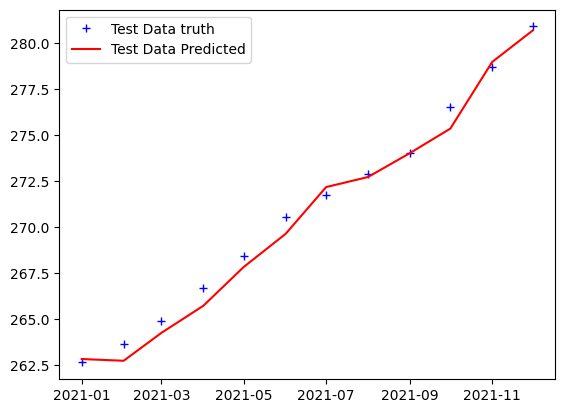

In [6]:
Y_predicted = regress_predict(Y_training[:],Y_test[:],3)
plt.plot(X[train_size:],Y_test,'b+',label = 'Test Data truth')
plt.plot(X[train_size:],Y_predicted,color='red', label = 'Test Data Predicted')
plt.legend()
plt.show()


## 2. AR(5)

Mape error : 0.2226941310240185 %, MSE: 0.5380107672175358


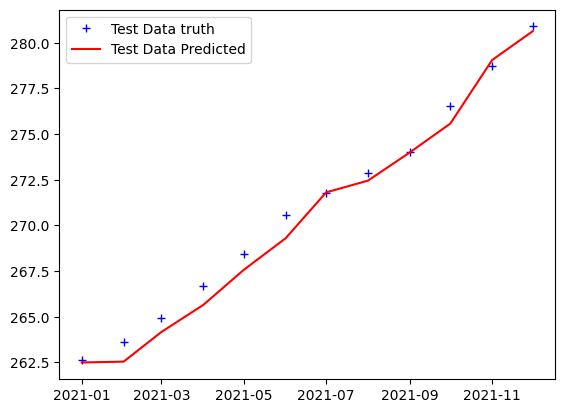

In [7]:
Y_predicted = regress_predict(Y_training[:],Y_test[:],5)
plt.plot(X[train_size:],Y_test,'b+',label = 'Test Data truth')
plt.plot(X[train_size:],Y_predicted,color='red', label = 'Test Data Predicted')
plt.legend()
plt.show()

In [8]:
def compute_EWMA(Y_training,Y_test,alpha):
     Y_estimate =[Y_training.iloc[-1]]
     mape = 0
     mse = 0
     count = 0
     for i in range(1,len(Y_test)):
         predicted = alpha*Y_test[i-1] + (1-alpha)*Y_estimate[i-1]
         Y_estimate.append(predicted)
         mape+= abs(predicted - Y_test[i])/Y_test[i]
         mse += ((predicted - Y_test[i])**2)
         count += 1

     mape = (mape*100)/count
     mse = mse/count
     print(f"Mape error : {mape} %, MSE: {mse}")

     return Y_estimate


## 3. EWMA with α = 0.5

Mape error : 1.0955311188100343 %, MSE: 9.677348515624784


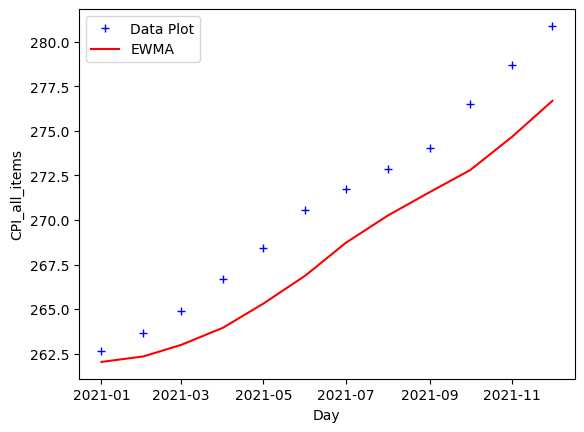

In [9]:

y_ewma = compute_EWMA(Y_training[:],Y_test[:],0.5)
plt.plot(X[len(Y_training):],Y_test,'b+',label='Data Plot')
plt.plot(X[len(Y_training):],y_ewma,color='red',label='EWMA')
plt.legend()
plt.xlabel('Day')
plt.ylabel('CPI_all_items')
plt.show()

## 4. EWMA with α = 0.8

Mape error : 0.7425117672107877 %, MSE: 4.4403986783154


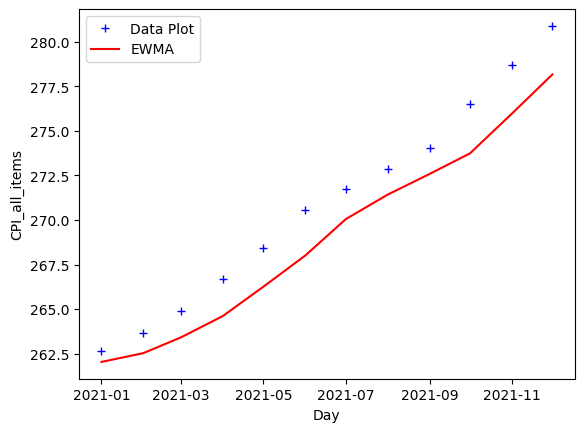

In [10]:

y_ewma = compute_EWMA(Y_training[:],Y_test[:],0.8)
plt.plot(X[len(Y_training):],Y_test,'b+',label='Data Plot')
plt.plot(X[len(Y_training):],y_ewma,color='red',label='EWMA')
plt.legend()
plt.xlabel('Day')
plt.ylabel('CPI_all_items')
plt.show()